In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cv2
from numpy.linalg import svd
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import PCA

import time
import torch

In [2]:
train_path = "./MRIscans/Training"
test_path = "./MRIscans/Testing"
val_path = "./MRIscans/Validation"
pca_path = "./MRIscans/PCAdataset"

In [3]:
def load_images(data_path, data_set_type: str):
    train_tumor = []
    test_no_tumor, test_tumor = [], []
    test_no_tumor_and_labels, test_tumor_and_labels = [], []
    val_images = []
    
    pca_tumor, pca_no_tumor = [], []
    
    
    if data_set_type == "train":
        for f in os.listdir(data_path):
            if f != '.DS_Store' and f == 'tumor':
                path = os.path.join(data_path+'/', f)
                for img in os.listdir(path):
                    if img.endswith(".jpeg") or img.endswith(".jpg"):
                        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                        # Resize images to all have same dimensions -> avoid large image data problems
                        new_img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = new_img_array.astype(float, copy=False)/255  
                        train_tumor.append(new_img_array)
                        
            elif f != '.DS_Store' and f == 'no_tumor_train':
                path = os.path.join(data_path+'/', f)
                for img in os.listdir(path):
                    if img.endswith(".jpeg") or img.endswith(".jpg"):
                        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                        # Resize images to all have same dimensions -> avoid large image data problems
                        new_img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = new_img_array.astype(float, copy=False)/255  
                        train_no_tumor.append(new_img_array)
            else:
                print("train folder does not exist!")
                        
    elif data_set_type == "test":
        for f in os.listdir(data_path):
            if f != '.DS_Store' and f == 'no_tumor':
                test_no_tumor_path = os.path.join(data_path+'/', f)
                for img in os.listdir(test_no_tumor_path):
                    if img.endswith(".jpeg") or img.endswith(".jpg"):
                        img_array = cv2.imread(os.path.join(test_no_tumor_path, img), cv2.IMREAD_GRAYSCALE)
                        img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = img_array.astype(float, copy=False)/255 
                        
                        # Here we create a list of tuples of the images along with their respective label.
                        # 1 = no_tumor (the anomaly). 0 = tumor (non-anomalous data)
                        test_no_tumor.append(new_img_array)
                        class_1 = np.ones(len(test_no_tumor))
                        test_no_tumor_and_labels = [test_no_tumor, class_1.tolist()]
                        
            
            if f == "tumor_test":
                test_tumor_path = os.path.join(data_path+'/', f)
                for img in os.listdir(test_tumor_path):
                    if img.endswith(".jpeg") or img.endswith(".jpg"):
                        img_array = cv2.imread(os.path.join(test_tumor_path, img), cv2.IMREAD_GRAYSCALE)
                        img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = img_array.astype(float, copy=False)/255  
                        test_tumor.append(new_img_array)
                        class_0 = np.zeros(len(test_tumor))
                        test_tumor_and_labels = [test_tumor, class_0.tolist()]
                        
    elif data_set_type == "PCAdataset":
        for f in os.listdir(data_path):
            if f != '.DS_Store' and f == 'no_tumor':
                test_no_tumor_path = os.path.join(data_path+'/', f)
                for img in os.listdir(test_no_tumor_path):
                    if img.endswith(".jpeg") or img.endswith(".jpg"):
                        img_array = cv2.imread(os.path.join(test_no_tumor_path, img), cv2.IMREAD_GRAYSCALE)
                        img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = img_array.astype(float, copy=False)/255 
                        
                        pca_no_tumor.append(new_img_array)
                        
            elif f != '.DS_Store' and f == 'tumor':
                test_no_tumor_path = os.path.join(data_path+'/', f)
                for img in os.listdir(test_no_tumor_path):
                    if img.endswith(".jpeg") or img.endswith(".jpg"):
                        img_array = cv2.imread(os.path.join(test_no_tumor_path, img), cv2.IMREAD_GRAYSCALE)
                        img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                        # normalize pixel values to be between 0 and 1
                        new_img_array = img_array.astype(float, copy=False)/255 
                        
                        pca_tumor.append(new_img_array)
            else:
                None
    
                
    else:
        for f in os.listdir(data_path):
            if f != '.DS_Store':
                validation_path = os.path.join(data_path+'/', f)
                try:
                    for img in os.listdir(os.path.abspath(validation_path)):
                        
                        if img.endswith(".jpeg") or img.endswith(".jpg"):
                            img_array = cv2.imread(os.path.join(validation_path, img), cv2.IMREAD_GRAYSCALE)
                            new_img_array = cv2.resize(img_array, (224, 224), interpolation = cv2.INTER_NEAREST)
                            # normalize pixel values to be between 0 and 1
                            new_img_array = new_img_array.astype(float, copy=False)/255  
                            val_images.append(new_img_array)
                except Exception as e:
                    raise e

                    
    return train_tumor, test_no_tumor_and_labels, test_tumor_and_labels, val_images, pca_tumor, pca_no_tumor

In [4]:
train_t, _,_,_,_,_ = load_images(train_path, 'train')


# test_no_labels and test_yes_labels are lists of two lists. 
# The first list contains the images. The second list contains the class label
_, test_no_labels, test_yes_labels, _,_,_ = load_images(test_path, 'test')

train folder does not exist!


Number of training samples: 5291; Number of test samples: 1558


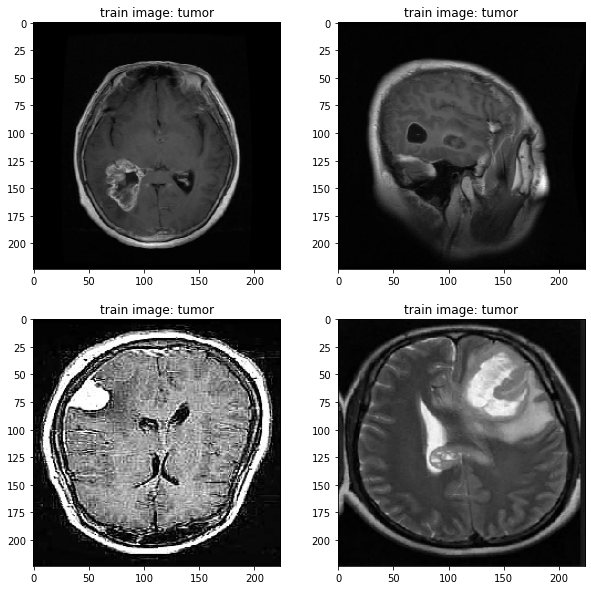

In [5]:
n_train_examples, n_test_examples = len(train_t), len(test_no_labels[0]) + len(test_yes_labels[0])
print(f"Number of training samples: {n_train_examples}; Number of test samples: {n_test_examples}")

# Plot some images from train and test sets
train_imgs = train_t[0:5]
test_imgs = test_no_labels[0][0:5]


plt.figure(figsize=(10, 10))
l =2
w = 2
for i in range(l*w):
    plt.subplot(l, w, i+1)
    plt.grid(False)
    plt.imshow(train_imgs[i], cmap='gray')
    plt.axis('on')
    plt.title("train image: tumor")

plt.show()

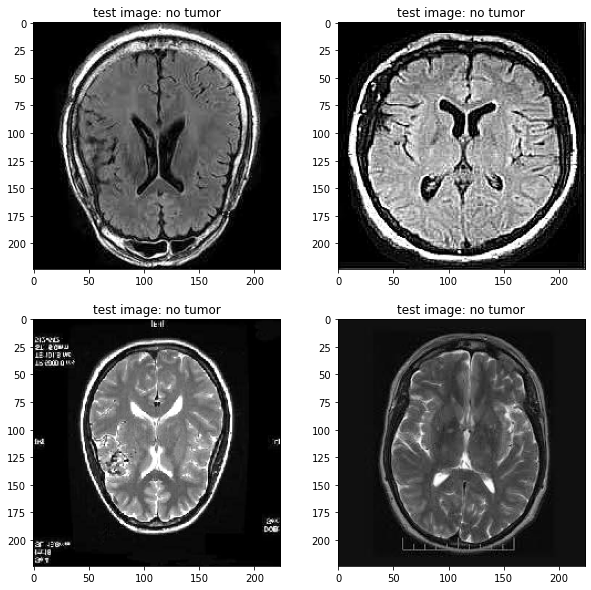

In [11]:
plt.figure(figsize=(10, 10))
l =2
w = 2
for i in range(l*w):
    plt.subplot(l, w, i+1)
    plt.grid(False)
    plt.imshow(test_imgs[i], cmap='gray')
    plt.axis('on')
    plt.title("test image: no tumor")

plt.show()

# Preprocessing

- Standardization: scale pixel values to have 0 mean and unit variance
- Noise reduction: remove any noise if present using cv2. ref: https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html
- Additional preprocessing steps...

In [5]:
def standardize(images):
    '''Accepts image list/array of shape: n x height*width'''
    standardized_images = []
    
    for img in images:
        stand_img = (img - np.mean(img, axis=0)) / np.std(img, axis=0)
        standardized_images.append(stand_img)
    return standardized_images

In [6]:
train_data = np.array(train_t)
train_data = np.reshape(train_data, newshape=(train_data.shape[0], train_data.shape[1]*train_data.shape[2]))
train_data_stand = standardize(train_data)

# Randomized SVD

In [9]:
# SVD vs randSVD for 1 image
A = train_data_stand[320].reshape((224, 224))

# regular svd
start = time.time()
U1, S1, V1 = svd(A)
end = time.time()
print('Reg SVD: ', end-start)

# randomized svd
start = time.time()
U2, S2, V2 = randomized_svd(A, n_components=30, random_state=0)
end = time.time()
print('Rnd SVD: ', end-start)

Reg SVD:  0.11338973045349121
Rnd SVD:  0.034005165100097656


In [11]:
# function that reconstructs images using randomized svd
def randSVD_recon(A, k, graph=False):
    U, S, V = randomized_svd(A, n_components=k, random_state=0)
    recon = np.dot(U[:,:k], V[:k,:] * S[:k].reshape(k,1))
    
    if (graph):
        _, ax = plt.subplots(1, 2, figsize=(10,6))
        
        ax[0].imshow(A, cmap='gray')
        ax[0].axis('off')
        ax[0].set_title('Original image')
        
        ax[1].imshow(recon, cmap='gray')
        ax[1].axis('off')
        ax[1].set_title(f'Compressed image with rank {k}')
    
        plt.show()
    
    return recon

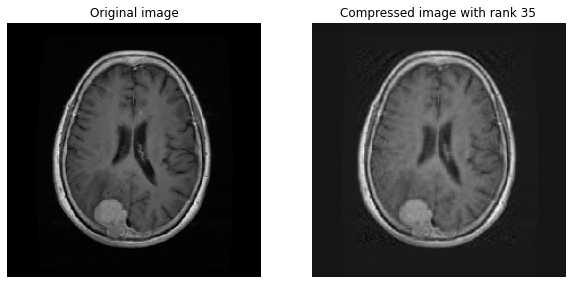

In [11]:
reconstructed_img = randSVD_recon(train_data_stand[320].reshape((224, 224)), k=35, graph=True)

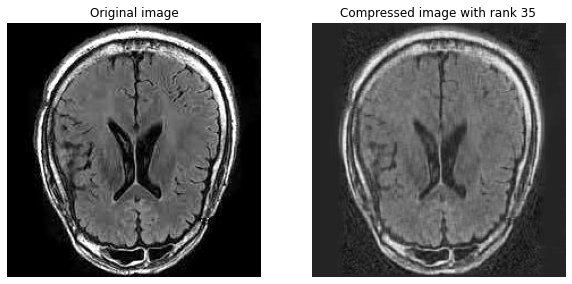

In [11]:
_ = randSVD_recon(test_imgs[0], k=35, graph=True)

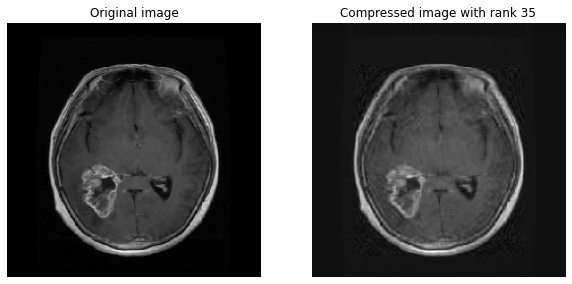

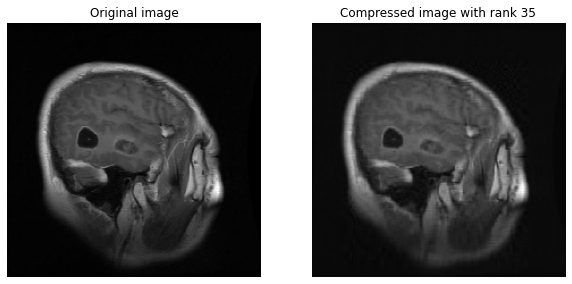

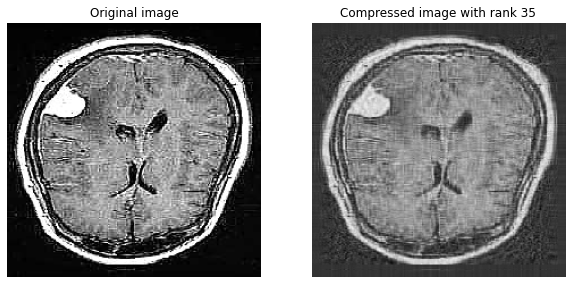

randSVD on training set: 27.992671966552734


In [12]:
# running reconstructor on all training images
graph_cond = True
start = time.time()
for i in range(len(train_data_stand)):
    _ = randSVD_recon(train_data_stand[i].reshape((224, 224)), k=35, graph=graph_cond)
    
    if i==2: graph_cond = False
end = time.time()
print('randSVD on training set:', end-start)

# Baseline anomaly detection model: PCA
- Compare original mri scans to scans represented in a new subspace
- Here, the "normal" mri scans are considered the anomalies. We wish to pass a dataset with a small percentage of anomalies with the hope of the model detecting salient features of tumorous brains -> distinguish these from normal brains
- Evaluate the comparisons using mean squared error
- The larger the error, the more likely the given image is an anomaly

In [15]:
def pca_anomaly_detection(X):
    
    X_df = pd.DataFrame(X)

    pca_model = PCA(n_components=2)  # 2 components has better results compared to 4
    # train the PCA model
    pca_model.fit(X_df)
    
    pca_subspace = pca_model.fit_transform(X_df)
    
    # space of images of original dimension (num features != pca components)
    inverse_subspace = pca_model.inverse_transform(pca_subspace)
    
    # computing mean squared errors between original images and pca constructed images
    mse_scores = ((X_df - inverse_subspace)**2).sum(axis=1)
    
    return mse_scores, X_df, pca_model

In [7]:
# Load the dataset containing tumor and non-tumor images

_, _, _, _, pca_t, pca_no_t = load_images(pca_path, "PCAdataset")

image_data = pca_t + pca_no_t
print(f"num of samples to pass to pca: {len(image_data)}")

samples = np.array(image_data)
samples = samples.reshape((samples.shape[0], samples.shape[1]*samples.shape[2]))

pca_samples_stand = standardize(samples)
p = np.array(pca_samples_stand)
p_tensor = torch.from_numpy(p)
p_tensor.size()

num of samples to pass to pca: 3419


torch.Size([3419, 50176])

In [8]:
# In an Unsupervised anomaly detection framework, the non-anomalous data count is typically >> # of anomalies

print(f"num tumor images to pass to pca: {len(pca_t)}")
print(f"num non-tumor images to pass to pca: {len(pca_no_t)}")

num tumor images to pass to pca: 144
num non-tumor images to pass to pca: 3275


In [9]:
# Random permutation of rows (shuffle the images)

torch.manual_seed(42)

p_tensor_shuffle = p_tensor[torch.randperm(p_tensor.size()[0])]
p_tensor_shuffle.size()

torch.Size([3419, 50176])

In [12]:
# Convert pytorch tensor of images to numpy
image_arrays = p_tensor_shuffle.numpy()
image_randSVDs = []

# Creating the randSVD reconstructions of images to be passed to PCA model

for img in image_arrays:
    image_randSVD = randSVD_recon(img.reshape((224, 224)), k=35, graph=False)
    image_randSVDs.append(image_randSVD)
print(image_randSVDs[0].shape)

(224, 224)


In [13]:
image_randSVDs = np.array(image_randSVDs)
image_randSVDs = np.reshape(image_randSVDs, newshape=(image_randSVDs.shape[0], image_randSVDs.shape[1]*image_randSVDs.shape[2]))
image_randSVDs.shape

(3419, 50176)

In [16]:
# Perform Anomaly Detection with PCA

start_pca = time.time()
scores, pca_df, pca = pca_anomaly_detection(image_randSVDs)
end_pca_time = time.time() - start_pca

print(f"Time to run PCA on randSVDs reconstructions: {end_pca_time}")
print('\n')
print(f"9 largest MSE scores after PCA: {scores.nlargest(9)}")

Time to run PCA on randSVDs reconstructions: 27.04168701171875


9 largest MSE scores after PCA: 871     67398.141571
1603    67398.141571
3132    56137.785796
328     53975.521656
392     53975.521656
679     53975.521656
2322    53975.521656
575     51455.841316
1981    50734.322580
dtype: float64


## Plot the 9 images correspond to the largest MSE scores -> large scores indicate anomalous images

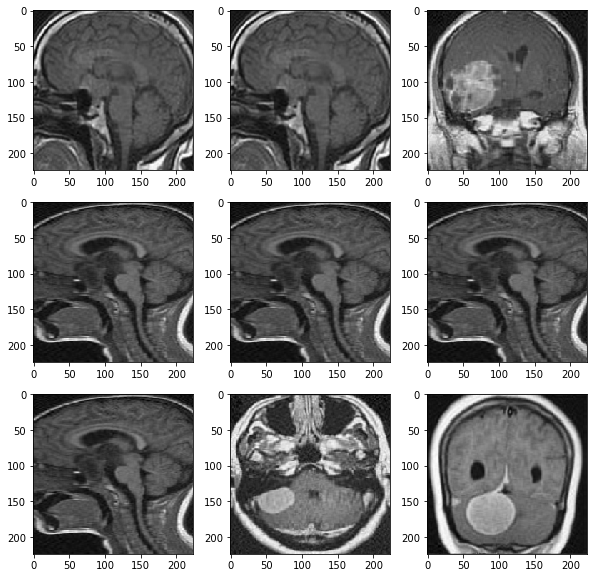

In [17]:
largest_mse_scores = scores.nlargest(9).index

plt.figure(figsize=(10, 10))
row, cols = 3, 3

for i in range(9):
    plt.subplot(row, cols, i+1)
    plt.imshow(pca_df.iloc[largest_mse_scores[i]].values.reshape((224, 224)), interpolation='nearest', cmap='gray')
    plt.grid(False)
plt.show()

## Evaluate the PCA model on the test set and visualize the MRI scans that PCA determined are anomalous

In [18]:
def run_evaluation(pca_model, test_no_tumor, test_tumor, standard_scaler, randSVD_transform, plot_pca=False):
    '''Here, we create a pipeline of transformations to make to images in the test set
            and then pass the processed images to the PCA model for evaluation.'''
    
    torch.manual_seed(42)

    
    test_no_t, y_test_no_t = test_no_tumor  # y_test_.. = labels
    test_t, y_test_t = test_tumor
    
    test_list = test_no_t + test_t
    y_test = np.array(y_test_no_t + y_test_t)
    # y_test = torch.from_numpy(y_test)
    # y_test_final = y_test[torch.randperm(y_test.size()[0])]
    
    test_array = np.array(test_list)
    test_array = np.reshape(test_array, newshape=(test_array.shape[0], test_array.shape[1]*test_array.shape[2]))
    
    test_stand = standard_scaler(test_array)
    test_array_stand = np.array(test_stand)
    test_tensor = torch.from_numpy(test_array_stand)
    
    # Shuffle the data 
    test_shuffle = test_tensor[torch.randperm(test_tensor.size()[0])]
    test_nparrays = test_shuffle.numpy()
    
    # Create image reconstructions using randSVD algorithm
    test_reconstructions = []
    
    for test_img in test_nparrays:
        test_recon = randSVD_transform(test_img.reshape((224, 224)), k=28, graph=False)
        test_reconstructions.append(test_recon)
    
    test_recons = np.array(test_reconstructions)
    test_data = np.reshape(test_recons, newshape=(test_recons.shape[0], test_recons.shape[1]*test_recons.shape[2]))
    
    test_df = pd.DataFrame(test_data)
    
    # Run PCA on test set
    test_pca_res = pca_model.transform(test_df)
    test_inverse_subspace = pca_model.inverse_transform(test_pca_res)
    
    test_eval_scores = ((test_df - test_inverse_subspace)**2).sum(axis=1)
    
    '''
    # Visualize PCA separability in two dimensions
    if plot_pca is True:
        
        # temp_df = pd.DataFrame(data=test_df.loc[:, 0:1], index=test_df.index)
        # temp_df = pd.concat((temp_df, y_test), axis=1, join='inner')
        # temp_df.columns = ["PCA vec 1", "PCA vec 2", "labels"]
        
        plt.figure(figsize=(12, 6))
        sns.scatterplot(x=test_pca_res[:, 0], y=test_pca_res[:, 1], hue= palette=["blue", "red"])
    plt.show()
    '''  
    return test_eval_scores, test_df

In [19]:
test_mse_scores, test_df = run_evaluation(pca, test_no_labels, test_yes_labels, standardize, randSVD_recon)

## Plot the test images with the highest MSE scores

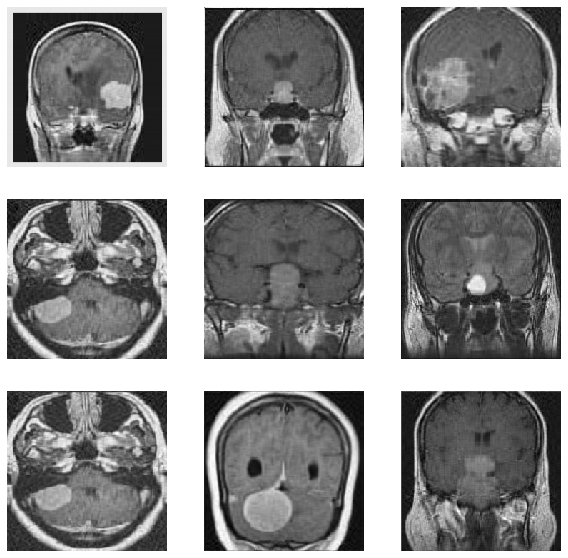

In [20]:
largest_test_mse = test_mse_scores.nlargest(9).index

plt.figure(figsize=(10, 10))
row, col = 3, 3

for i in range(9):
    plt.subplot(row, col, i+1)
    plt.imshow(test_df.iloc[largest_test_mse[i]].values.reshape((224, 224)), interpolation='nearest', cmap='gray')
    plt.axis('off')
plt.show()